# Deep Evidential Regression

## Theoretic Foundation / Papers where it was introduced

Deep Evidential Regression (DER) [Amini, 2020](https://proceedings.neurips.cc/paper/2020/file/aab085461de182608ee9f607f3f7d18f-Paper.pdf) is a single forward pass UQ method that aims to disentangle aleatoric and epistemic uncertainty.  DER entails a four headed network output 

$$
    f_{\theta}(x^{\star})=(\gamma_{\theta}(x^{\star}), \nu_{\theta}(x^{\star}), \alpha_{\theta}(x^{\star}), \beta_{\theta}(x^{\star})),
$$

that is used to compute the predictive t-distribution with $2\alpha(x^{\star})$ degrees of freedom:

$$
    p(y(x^{\star})|f_{\theta}(x^{\star}))=\text{St}_{2\alpha_{\theta}(x^{\star})}\left(y^{\star}\bigg| \gamma_{\theta}(x^{\star}), \frac{\beta_{\theta}(x^{\star})(1+\nu_{\theta}(x^{\star}))}{\nu_{\theta}(x^{\star})\alpha_{\theta}(x^{\star})}\right).
$$

In [Amini, 2020](https://proceedings.neurips.cc/paper/2020/file/aab085461de182608ee9f607f3f7d18f-Paper.pdf) the network weights are obtained by minimizing the loss objective that is the negative log-likelihood of the predictive distribution and a regularization term. However, due to several drawbacks of DER, \cite{meinert2023unreasonable} propose the following adapted loss objective that we also utilise,

$$
    \mathcal{L}({\theta},(x^{\star}, y^{\star}))=\log\sigma_{\theta}^2(x^{\star})+(1+\lambda\nu_{\theta}(x^{\star}))\frac{(y^{\star}-\gamma_{\theta}(x^{\star}))^2}{\sigma_{\theta}^2(x^{\star})}
$$

where $\sigma_{\theta}^2(x^{\star})=\beta_{\theta}(x^{\star})/\nu_{\theta}(x^{\star})$. Further following [Meinert, 2022](https://ojs.aaai.org/index.php/AAAI/article/view/26096), we use their reformulation of the uncertainty decomposition. The aleatoric uncertainty is given by

$$
    u_{\text{aleatoric}}(x^{\star})=\sqrt{\frac{\beta(x^{\star})}{\alpha(x^{\star})-1}},
$$

and the epistemic uncertainy by,

$$
    u_{\text{epistemic}}(x^{\star})=\frac{1}{\sqrt{\nu(x^{\star})}}.
$$

The predictive uncertainty is then, given by 

$$
    u(x^{\star}) = \sqrt{u_{\text{epistemic}}(x^{\star})^2+u_{\text{aleatoric}}(x^{\star})^2} .
$$




## Imports

In [1]:
import os

import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.datamodules import ToyHeteroscedasticDatamodule
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import DER
from lightning_uq_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions_regression,
    plot_toy_regression_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

In [2]:
seed_everything(0)  # seed everything for reproducibility

Seed set to 0


0

We define a temporary directory to look at some training metrics and results.

In [3]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

To demonstrate the method, we will make use of a Toy Regression Example that is defined as a [Lightning Datamodule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). While this might seem like overkill for a small toy problem, we think it is more helpful how the individual pieces of the library fit together so you can train models on more complex tasks.

In [4]:
dm = ToyHeteroscedasticDatamodule()

X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)

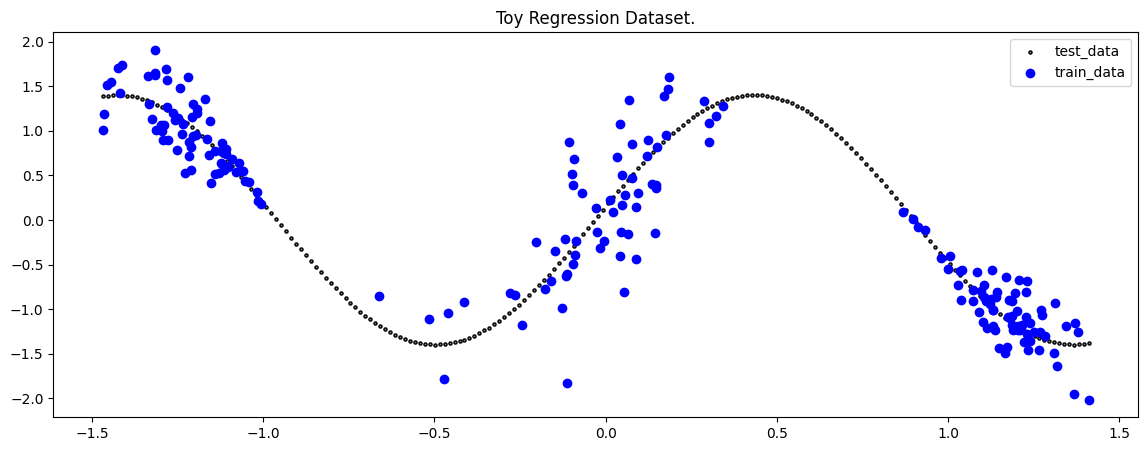

In [5]:
plot_toy_regression_data(X_train, y_train, X_test, y_test)

## Model

For our Toy Regression problem, we will use a simple Multi-layer Perceptron (MLP) that you can configure to your needs. For the documentation of the MLP see [here](https://readthedocs.io/en/stable/api/models.html#MLP). For the DER Model our underlying network will require 4 outputs that feed into a DERLayer based on which the loss function will be computed.

In [6]:
network = MLP(n_inputs=1, n_hidden=[50, 50, 50], n_outputs=4, activation_fn=nn.Tanh())
network

MLP(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Tanh()
    (8): Dropout(p=0.0, inplace=False)
    (9): Linear(in_features=50, out_features=4, bias=True)
  )
)

With an underlying neural network, we can now use our desired UQ-Method as a sort of wrapper. All UQ-Methods are implemented as [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) that allow us to concisely organize the code and remove as much boilerplate code as possible.

In [7]:
der_model = DER(network, optimizer=partial(torch.optim.Adam, lr=1e-3))

## Trainer

Now that we have a LightningDataModule and a UQ-Method as a LightningModule, we can conduct training with a [Lightning Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html). It has tons of options to make your life easier, so we encourage you to check the documentation.

In [8]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=250,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training our model is now easy:

In [9]:
trainer.fit(der_model, dm)

Missing logger folder: /tmp/tmpln6yd7_k/lightning_logs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Sequential       | 5.4 K 
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | loss_fn       | DERLoss          | 0     
---------------------------------------------------
5.4 K     Trainable params
0         Non-trainable params
5.4 K     Total params
0.022     Total estimated model params size (MB)
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.

## Training Metrics

To get some insights into how the training went, we can use the utility function to plot the training loss and RMSE metric.

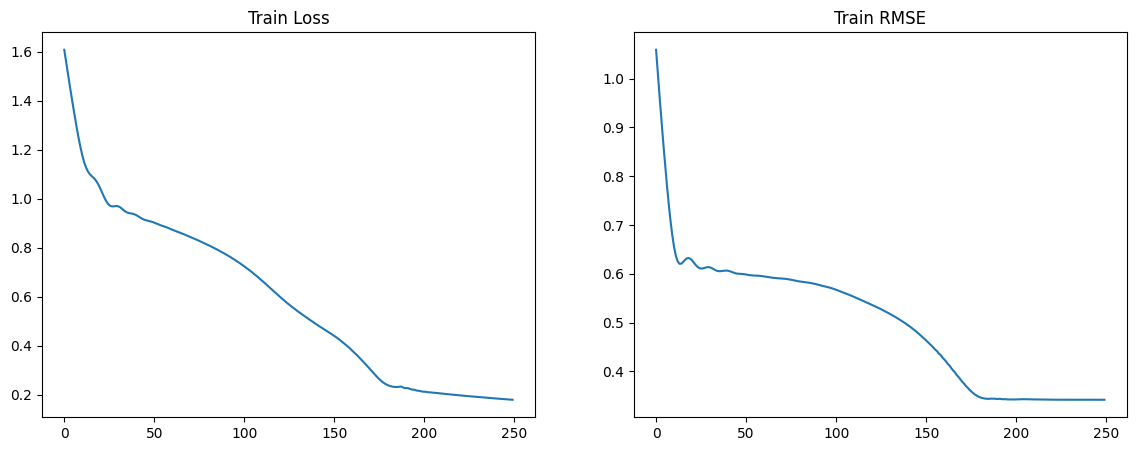

In [10]:
fig = plot_training_metrics(os.path.join(my_temp_dir, "lightning_logs"), "RMSE")

## Prediction

In [11]:
preds = der_model.predict_step(X_test)

## Evaluate Predictions

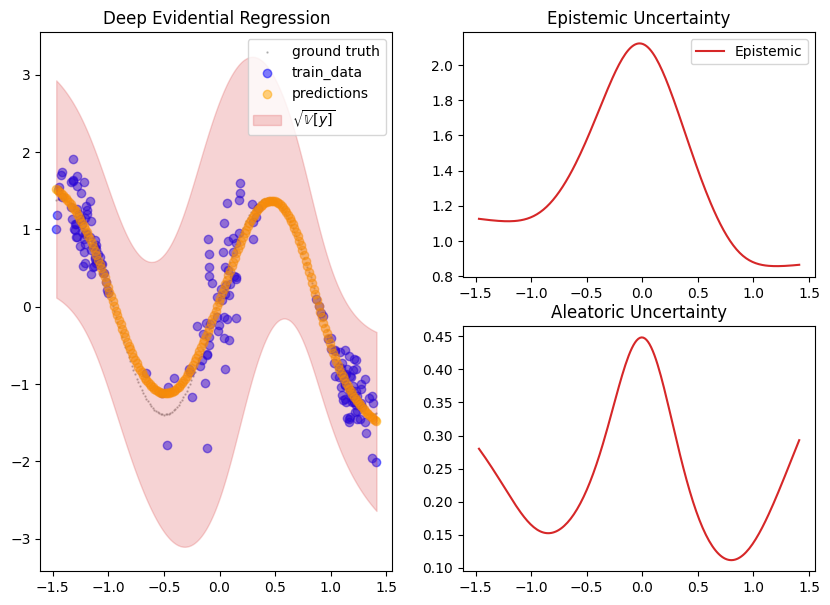

In [12]:
fig = plot_predictions_regression(
    X_train,
    y_train,
    X_test,
    y_test,
    preds["pred"],
    preds["pred_uct"],
    epistemic=preds["epistemic_uct"],
    aleatoric=preds["aleatoric_uct"],
    title="Deep Evidential Regression",
    show_bands=False,
)

<Figure size 1400x500 with 0 Axes>

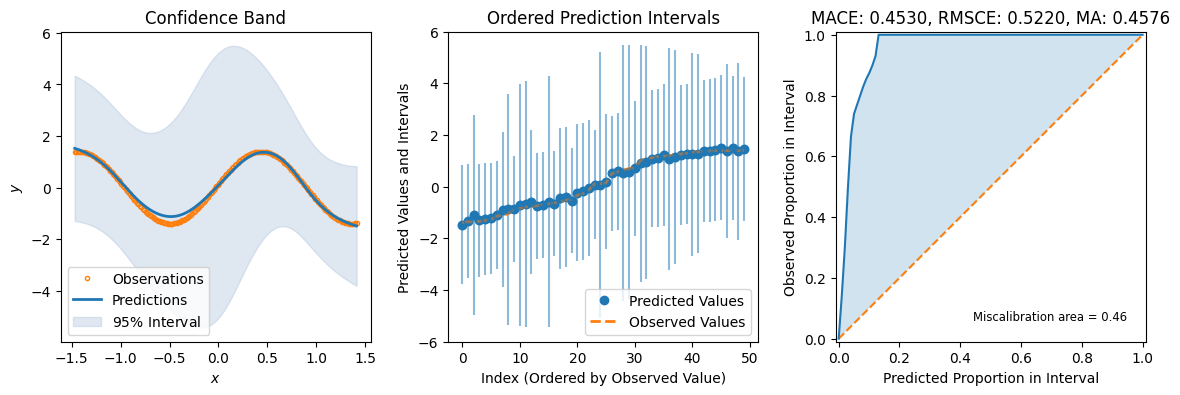

In [13]:
fig = plot_calibration_uq_toolbox(
    preds["pred"].cpu().numpy(),
    preds["pred_uct"],
    y_test.cpu().numpy(),
    X_test.cpu().numpy(),
)